<a href="https://colab.research.google.com/github/PacktPublishing/Machine-Learning-for-Time-Series-with-Python/blob/master/chapter5/Forecasting.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
#!pip install statsmodels yfinance pmdarima arch

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pandas as pd

sns.set_style("whitegrid")
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "17"
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 1
# plt.style.use('.matplotlibrc')

In [34]:
from datetime import datetime
import yfinance as yf
  
start_date = datetime(2005, 1, 1)
end_date = datetime(2021, 1, 1)

df = yf.download(
    'SPY',
    start=start_date,
    end = end_date
)

[*********************100%***********************]  1 of 1 completed


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

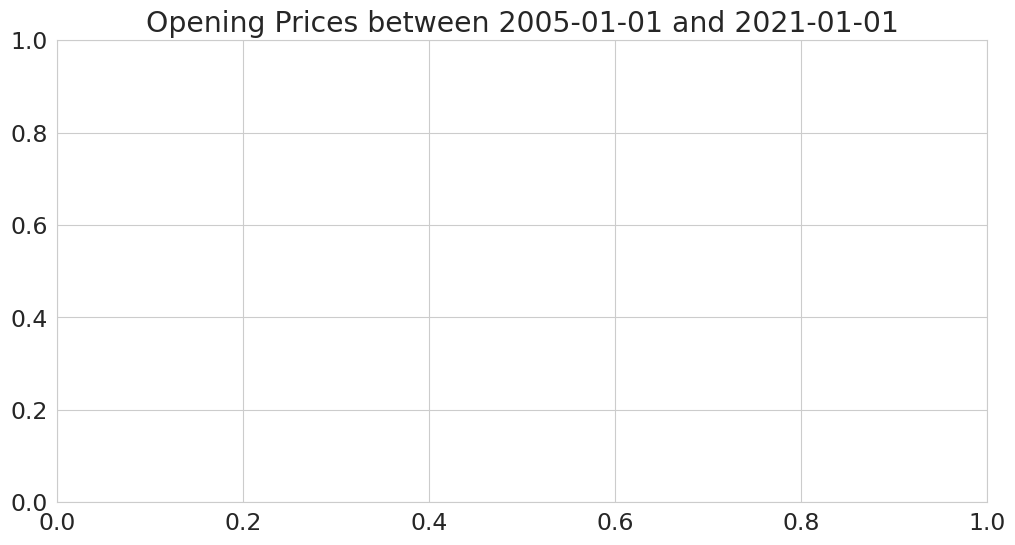

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

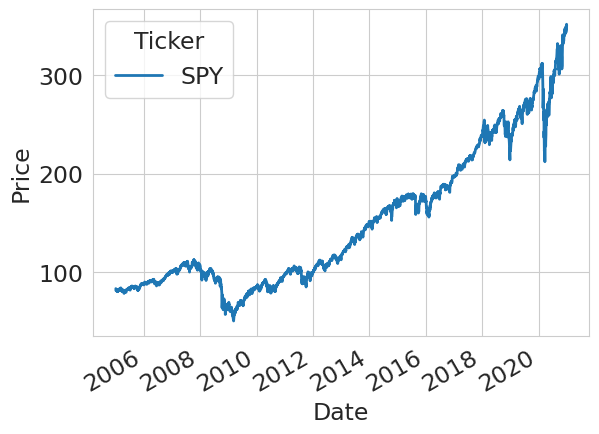

In [35]:
plt.figure(figsize = (12, 6))
plt.title('Opening Prices between {} and {}'.format(
    start_date.date().isoformat(),
    end_date.date().isoformat()
))
df['Open'].plot()
plt.ylabel('Price')
plt.xlabel('Date');

In [36]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2005-01-03,82.316681,83.315702,82.042975,83.178847,55748000
2005-01-04,81.310799,82.480885,81.043937,82.426143,69167600
2005-01-05,80.749733,81.598216,80.742889,81.249241,65667300
2005-01-06,81.160301,81.529803,80.920811,81.043978,47814700
2005-01-07,81.043945,81.584513,80.831821,81.406603,55847700


In [37]:
df1 = df.reset_index().resample('W', on="Date")['Open'].mean()

In [38]:
# some years have 53 weeks. We can't handle that, so we'll get rid of the 53rd week.
df1 = df1[df1.index.isocalendar().week < 53]


<Axes: xlabel='week'>

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

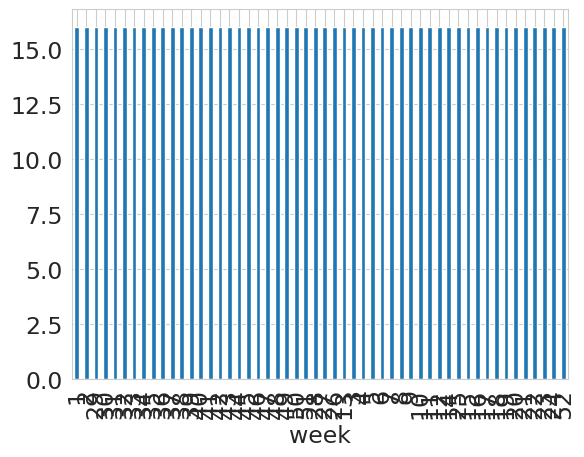

In [39]:
# final check: 
df1.index.isocalendar().week.value_counts().plot.bar()


In [40]:
df1 = df1[~df1.isnull()]

In [41]:
# let's fix the frequency:
df1 = df1.asfreq('W').fillna(method='ffill')

/tmp/ipykernel_235565/109640341.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df1 = df1.asfreq('W').fillna(method='ffill')


In [42]:
df1.index.freq

<Week: weekday=6>

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

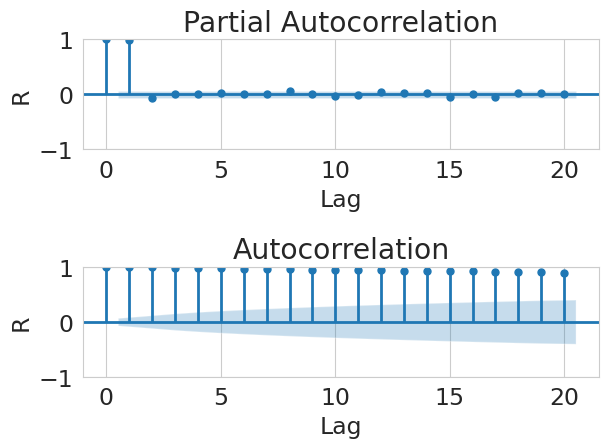

In [43]:
import statsmodels.api as sm

fig, axs = plt.subplots(2)
sm.graphics.tsa.plot_pacf(df1, lags=20, ax=axs[0])
axs[0].set_ylabel('R')
axs[0].set_xlabel('Lag')
sm.graphics.tsa.plot_acf(df1, lags=20, ax=axs[1]);
axs[1].set_ylabel('R')
axs[1].set_xlabel('Lag')
fig.tight_layout()

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

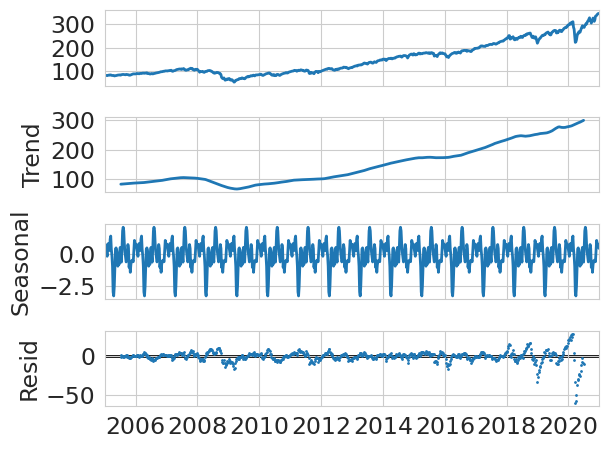

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df1, model='additive', period=52)
result.plot();

# Finding a value for d

We are using the ARCH package which has more convenient versions of both the ADF and the KPSS tests.

In [45]:
from arch.unitroot import KPSS, ADF

ADF(df1)

Test Statistic,1.892
P-value,0.999
Lags,9


In [46]:
from pmdarima.arima.utils import ndiffs

# ADF Test:
ndiffs(df1, test='adf')  # 1; same values for the KPSS and the PP test

/root/miniconda3/envs/TimeSeries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/miniconda3/envs/TimeSeries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/miniconda3/envs/TimeSeries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/miniconda3/envs/TimeSeries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/miniconda3/envs/TimeSeries/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' wa

1

In [47]:
# what happens if we forget differencing?
# We get a helful warning: 'Non-stationary starting autoregressive parameters'
mod = sm.tsa.arima.ARIMA(endog=df1, order=(1, 0, 0))
res = mod.fit()
print(res.summary())

/root/miniconda3/envs/TimeSeries/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                    SPY   No. Observations:                  834
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2145.814
Date:                Thu, 08 May 2025   AIC                           4297.628
Time:                        13:20:33   BIC                           4311.807
Sample:                    01-09-2005   HQIC                          4303.064
                         - 12-27-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        151.7101    388.701      0.390      0.696    -610.130     913.550
ar.L1          0.9997      0.001    671.940      0.000       0.997       1.003
sigma2         9.9660      0.152     65.371      0.0

In [48]:
# let's try again and this time, we'll take into account the seasonality:
from statsmodels.tsa.forecasting.stl import STLForecast

mod = STLForecast(df1, sm.tsa.arima.ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"))
res = mod.fit().model_result
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  834
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1841.822
Date:                Thu, 08 May 2025   AIC                           3689.643
Time:                        13:20:33   BIC                           3703.818
Sample:                    01-09-2005   HQIC                          3695.078
                         - 12-27-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2964      0.104      2.846      0.004       0.092       0.501
ar.L1          0.2642      0.020     13.435      0.000       0.226       0.303
sigma2         4.8752      0.124     39.210      0.0

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

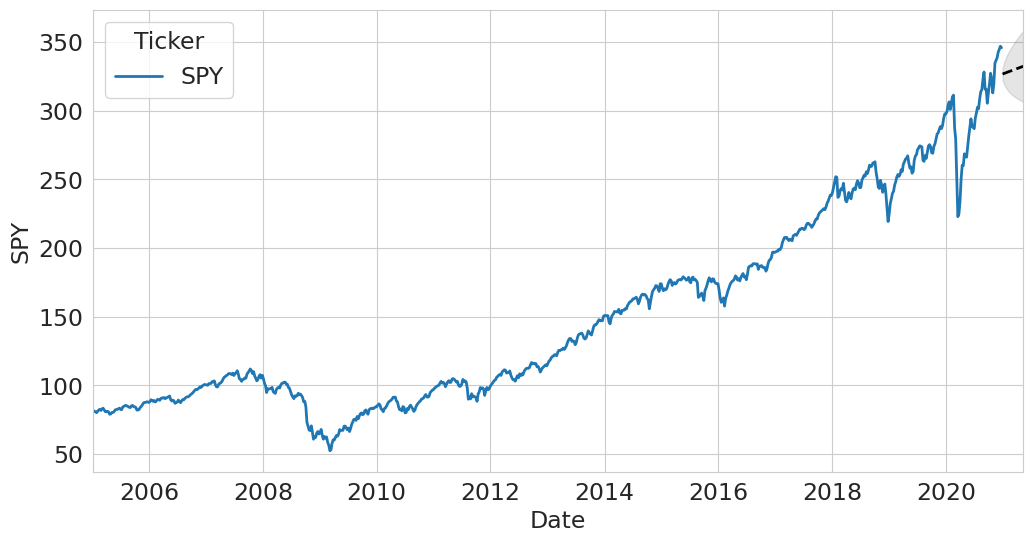

In [49]:
# doing a forecast:
STEPS = 20
forecasts_df = res.get_forecast(steps=STEPS).summary_frame() 
ax = df1.plot(figsize=(12, 6))
plt.ylabel('SPY')
forecasts_df['mean'].plot(style='k--')
ax.fill_between(
    forecasts_df.index,
    forecasts_df['mean_ci_lower'],
    forecasts_df['mean_ci_upper'],
    color='k',
    alpha=0.1
)

In [50]:
forecasts = []
qs = []
for q in range(0, 30, 10):
    mod = STLForecast(df1, sm.tsa.arima.ARIMA, model_kwargs=dict(order=(0, 1, q), trend="t"))
    res = mod.fit().model_result
    print(f"aic ({q}): {res.aic}")
    forecasts.append(
            res.get_forecast(steps=STEPS).summary_frame()['mean']
        )
    qs.append(q)

forecasts_df = pd.concat(forecasts, axis=1)
forecasts_df.columns = qs

aic (0): 3747.9981590229463
aic (10): 3687.7929943650397
aic (20): 3685.1505052028215


<Axes: xlabel='Date', ylabel='SPY'>

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

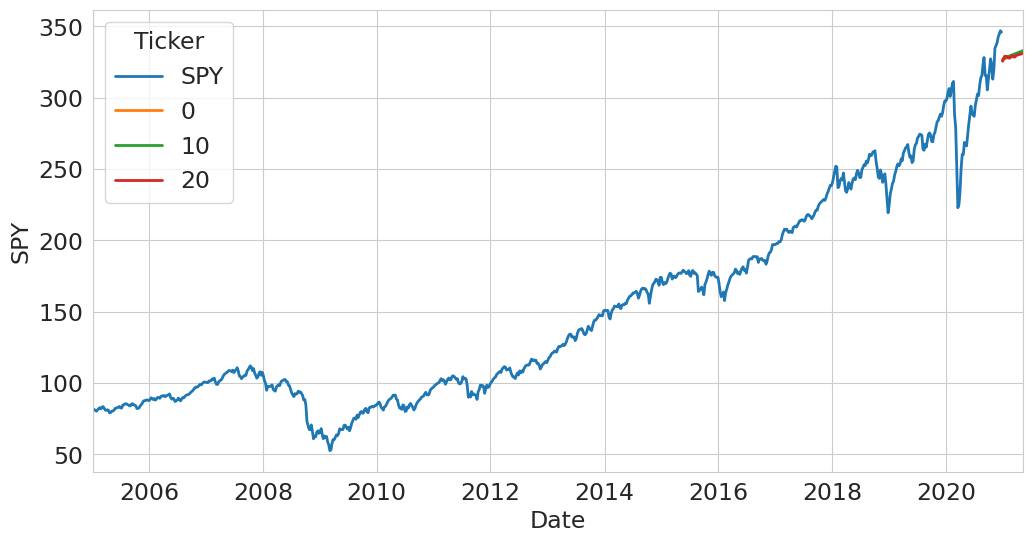

In [51]:
# plotting the three forecasts:
ax = df1.plot(figsize=(12, 6))
plt.ylabel('SPY')
forecasts_df.plot(ax=ax)

In [52]:
mod = sm.tsa.ExponentialSmoothing(
        endog=df1, trend='add', seasonal_periods=52, use_boxcox=True, initialization_method="heuristic"
    )
res = mod.fit()
print(res.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                      SPY   No. Observations:                  834
Model:             ExponentialSmoothing   SSE                           8217.131
Optimized:                         True   AIC                           1915.978
Trend:                         Additive   BIC                           1934.883
Seasonal:                          None   AICC                          1916.079
Seasonal Periods:                  None   Date:                 Thu, 08 May 2025
Box-Cox:                           True   Time:                         13:20:35
Box-Cox Coeff.:                -0.37619                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
smoothing_trend            0.00483

<Axes: xlabel='Date', ylabel='SPY'>

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

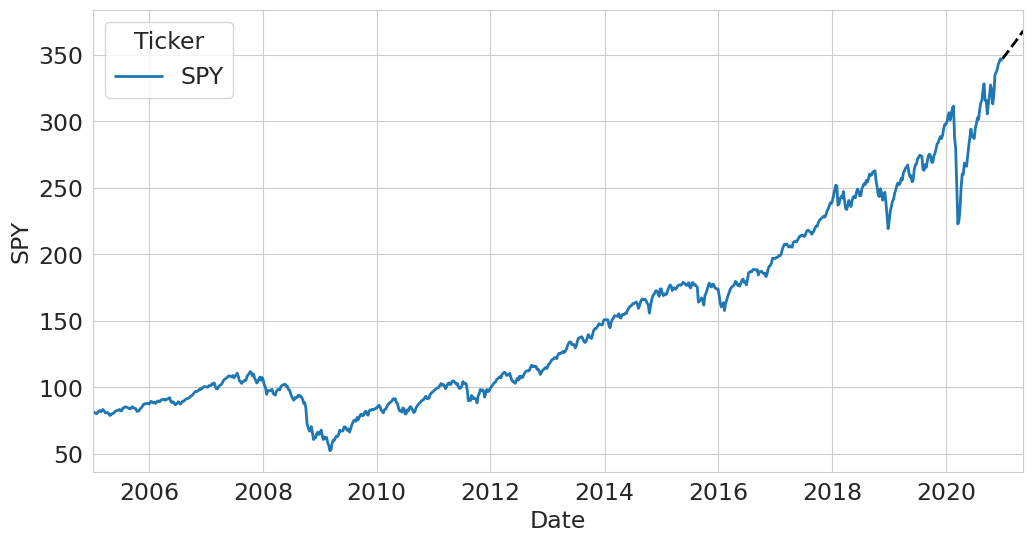

In [53]:
forecasts = pd.Series(res.forecast(steps=STEPS))
ax = df1.plot(figsize=(12, 6))
plt.ylabel('SPY')
forecasts.plot(style='k--')

<Axes: xlabel='Date', ylabel='SPY'>

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

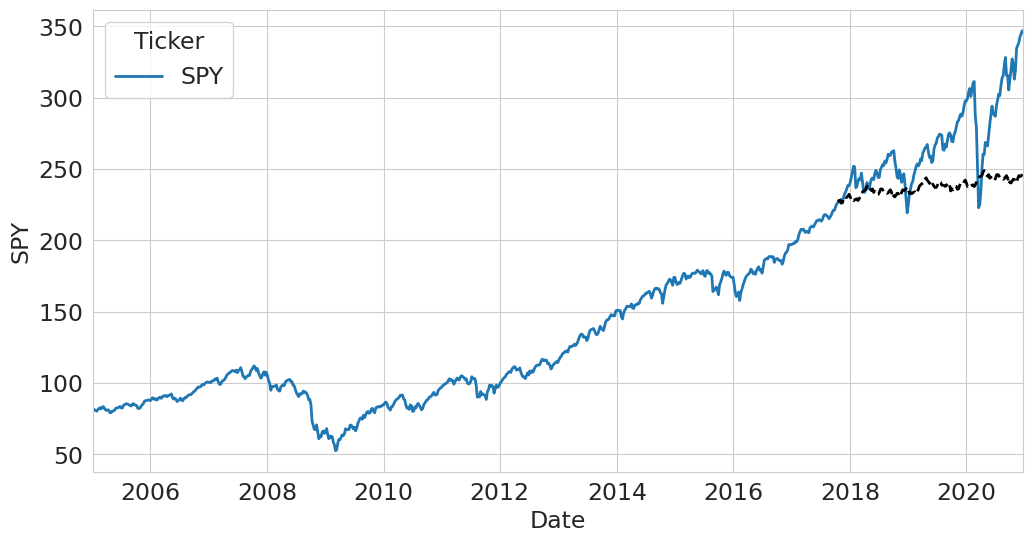

In [54]:
from statsmodels.tsa.forecasting.theta import ThetaModel

train_length = int(len(df1) * 0.8)
tm = ThetaModel(df1[:train_length], method="auto", deseasonalize=True)
res = tm.fit()
forecasts = res.forecast(steps=len(df1)-train_length)
ax = df1.plot(figsize=(12, 6))
plt.ylabel('SPY')
forecasts.plot(style='k--')

In [55]:
from sklearn import metrics

metrics.mean_squared_error(forecasts, df1[train_length:])

1636.0834679664931